In [1]:

3# Cell 1: import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Optional: handle class imbalance
try:
    from imblearn.over_sampling import SMOTE
    imblearn_available = True
except Exception:
    imblearn_available = False
    print("imblearn not installed — you can install it with: pip install imblearn")

In [2]:
# Cell 2: load dataset (tab-separated)
file_path = r'C:\Users\u\Desktop\india.csv'
df = pd.read_csv(file_path, sep=',') # sep='\t' for tab-separated files
# Quick look 
print("Rows,Cols:", df.shape)
display(df.head())


Rows,Cols: (7953, 10)


,transaction_id,customer_id,merchant_id,amount,transaction_time,card_type,location,purchase_category,customer_age,is_fraudulent
0,1.0,684415.0,2028.0,1262.770,11/24/2023 22:39,Rupay,Bangalore,NaN,28.0,0.0
1,2.0,447448.0,2046.0,2222.928,03/30/2024 16:18,MasterCard,Surat,POS,62.0,0.0
2,3.0,975001.0,2067.0,7509.832,03/07/2024 18:27,MasterCard,Hyderabad,POS,24.0,0.0
3,4.0,976547.0,NaN,2782.965,02/01/2024 0:58,Rupay,Hyderabad,Digital,62.0,0.0
4,5.0,935741.0,2044.0,NaN,12/22/2023 18:42,NaN,Bangalore,Digital,19.0,0.0


In [3]:
# Cell 3: Set target column
target_col = 'is_fraudulent'  # column to predict

# Convert transaction_time to datetime and extract numeric features
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')
df['hour'] = df['transaction_time'].dt.hour.fillna(0).astype(int)
df['month'] = df['transaction_time'].dt.month.fillna(0).astype(int)
df['day'] = df['transaction_time'].dt.day.fillna(0).astype(int)

# Drop original transaction_time (we already extracted numeric features)
df.drop(columns=['transaction_time'], inplace=True)

# Fill missing numeric columns with 0
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Handle categorical columns using one-hot encoding
categorical_cols = ['card_type','location','purchase_category']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())                                                                                   

Features shape: (7953, 20)
Target distribution:
 is_fraudulent
0.0    5688
1.0    2265
Name: count, dtype: int64


In [4]:
# Cell 4: Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)                                                                               

Train: (6362, 20) Test: (1591, 20)


In [5]:
# Cell 5: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Cell 6: Optional SMOTE oversampling
if imblearn_available:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    print("After SMOTE, class counts:", np.bincount(y_train_res))
else:
    X_train_res, y_train_res = X_train_scaled, y_train
    print("SMOTE not used, using original training set:", np.bincount(y_train_res))                                              

After SMOTE, class counts: [4550 4550]


In [7]:
# Cell 7: Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # helps with imbalanced classes
)
rf.fit(X_train_res, y_train_res)                                                                                     

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9956    1.0000    0.9978      1138
         1.0     1.0000    0.9890    0.9945       453

    accuracy                         0.9969      1591
   macro avg     0.9978    0.9945    0.9961      1591
weighted avg     0.9969    0.9969    0.9969      1591

ROC-AUC: 1.0


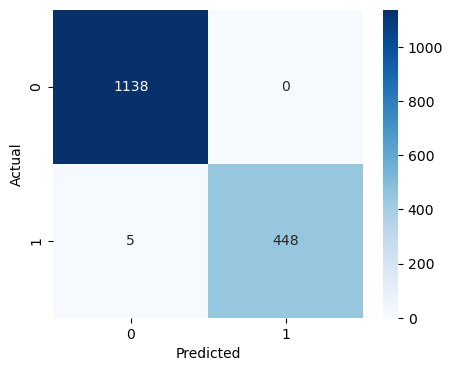

In [8]:
# Cell 8: Predictions
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

roc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", round(roc,4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# Cell 9: CREDIT CARD FRAUD DETECTION RESULTS (Original Numbers)

# 1. Make predictions on scaled test set
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# 2. Add predictions and actual labels to a copy of the ORIGINAL test data
fraud_predictions = X_test.copy()  # use unscaled numbers
fraud_predictions['Predicted'] = y_pred
fraud_predictions['Actual'] = y_test.values
fraud_predictions['Fraud_Probability'] = y_prob

# 3. Reset index for clean display
fraud_predictions = fraud_predictions.reset_index(drop=True)

# 4. Show top 10 predictions for overview
print("All Predictions Overview (Original Numbers):")
display(fraud_predictions.head(10))

# 5. Show only predicted fraudulent transactions
fraud_only = fraud_predictions[fraud_predictions['Predicted'] == 1]
print("Predicted Fraudulent Transactions (Original Numbers):")
display(fraud_only)

# 6. Show top 10 transactions with highest fraud probability
print("Top 10 Transactions with Highest Fraud Probability:")
display(fraud_predictions.sort_values(by='Fraud_Probability', ascending=False).head(10))

All Predictions Overview (Original Numbers):


,transaction_id,customer_id,merchant_id,amount,customer_age,hour,month,day,card_type_Rupay,card_type_Visa,...,location_Hyderabad,location_Jaipur,location_Kolkata,location_Mumbai,location_Pune,location_Surat,purchase_category_POS,Predicted,Actual,Fraud_Probability
0,1057.0,442047.0,2033.0,9659.268,52.0,22,3,26,False,True,...,False,False,False,False,False,False,True,0.0,0.0,0.000
1,546.0,507697.0,2097.0,384.384,43.0,22,1,30,False,True,...,False,False,True,False,False,False,False,0.0,0.0,0.015
2,0.0,645180.0,2024.0,9635.770,20.0,20,11,26,True,False,...,False,False,False,False,False,False,True,1.0,1.0,1.000
3,796.0,581358.0,2085.0,0.000,54.0,19,9,11,False,True,...,False,True,False,False,False,False,True,0.0,0.0,0.005
4,475.0,483215.0,2042.0,7351.995,61.0,5,1,8,False,False,...,False,False,True,False,False,False,False,1.0,1.0,1.000
5,661.0,671511.0,2089.0,5397.840,38.0,13,11,13,False,True,...,False,False,False,False,False,False,False,0.0,0.0,0.000
6,810.0,348089.0,2032.0,10362.187,43.0,12,1,17,True,False,...,False,False,False,False,False,False,False,0.0,0.0,0.020
7,0.0,671432.0,2009.0,284.240,58.0,16,11,27,True,False,...,False,True,False,False,False,False,True,0.0,0.0,0.000
8,250.0,872761.0,2097.0,6610.570,44.0,16,9,6,False,False,...,False,False,True,False,False,False,True,0.0,0.0,0.000
9,1112.0,708508.0,2000.0,10527.176,40.0,10,10,16,False,False,...,False,False,False,False,False,False,False,0.0,0.0,0.000


Predicted Fraudulent Transactions (Original Numbers):


,transaction_id,customer_id,merchant_id,amount,customer_age,hour,month,day,card_type_Rupay,card_type_Visa,...,location_Hyderabad,location_Jaipur,location_Kolkata,location_Mumbai,location_Pune,location_Surat,purchase_category_POS,Predicted,Actual,Fraud_Probability
2,0.0,645180.0,2024.0,9635.770,20.0,20,11,26,True,False,...,False,False,False,False,False,False,True,1.0,1.0,1.000
4,475.0,483215.0,2042.0,7351.995,61.0,5,1,8,False,False,...,False,False,True,False,False,False,False,1.0,1.0,1.000
14,831.0,313503.0,2048.0,533.720,30.0,17,10,17,True,False,...,False,False,False,False,True,False,False,1.0,1.0,0.995
17,327.0,155159.0,2088.0,6578.810,0.0,6,11,25,False,False,...,False,False,True,False,False,False,False,1.0,1.0,1.000
21,902.0,899517.0,2075.0,4663.008,47.0,7,3,1,False,False,...,False,False,False,False,False,False,False,1.0,1.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,511.0,295481.0,2019.0,0.000,48.0,1,11,19,False,False,...,False,False,False,False,False,False,False,1.0,1.0,0.980
1578,148.0,280587.0,2000.0,9641.505,0.0,5,11,7,True,False,...,False,False,False,False,True,False,False,1.0,1.0,0.990
1579,1153.0,578518.0,2011.0,4998.888,28.0,8,1,22,False,True,...,False,False,False,True,False,False,False,1.0,1.0,1.000
1581,238.0,344115.0,2080.0,13389.360,46.0,0,0,0,True,False,...,False,False,False,False,False,False,False,1.0,1.0,1.000


Top 10 Transactions with Highest Fraud Probability:


,transaction_id,customer_id,merchant_id,amount,customer_age,hour,month,day,card_type_Rupay,card_type_Visa,...,location_Hyderabad,location_Jaipur,location_Kolkata,location_Mumbai,location_Pune,location_Surat,purchase_category_POS,Predicted,Actual,Fraud_Probability
1224,190.0,807678.0,2053.0,6937.010,25.0,8,3,7,False,False,...,False,False,False,False,False,False,False,1.0,1.0,1.0
337,857.0,902844.0,2021.0,1710.260,64.0,9,3,20,False,True,...,False,False,False,False,False,False,False,1.0,1.0,1.0
1008,771.0,289476.0,2062.0,6600.495,28.0,0,3,25,True,False,...,False,True,False,False,False,False,False,1.0,1.0,1.0
1311,916.0,0.0,2023.0,2738.960,34.0,22,9,11,False,True,...,False,False,False,False,False,False,False,1.0,1.0,1.0
331,720.0,670174.0,2002.0,15832.512,33.0,4,2,17,True,False,...,False,False,False,True,False,False,True,1.0,1.0,1.0
330,529.0,692974.0,2055.0,6929.160,23.0,23,10,1,False,False,...,False,False,False,False,False,False,False,1.0,1.0,1.0
329,547.0,421487.0,2087.0,768.669,35.0,15,9,15,True,False,...,True,False,False,False,False,False,False,1.0,1.0,1.0
328,1184.0,346830.0,2077.0,10173.912,24.0,7,11,3,False,False,...,False,False,False,False,False,False,False,1.0,1.0,1.0
327,979.0,155907.0,2013.0,6154.560,48.0,18,9,29,False,True,...,False,False,False,False,False,True,False,1.0,1.0,1.0
1313,771.0,289476.0,2062.0,6600.495,28.0,0,3,25,True,False,...,False,True,False,False,False,False,False,1.0,1.0,1.0


In [10]:
# Cell 10: Feature importance
importances = rf.feature_importances_
feat_names = X.columns
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
display(imp_df.head(20))

,feature,importance
1,customer_id,0.121006
0,transaction_id,0.117497
3,amount,0.115663
2,merchant_id,0.112055
7,day,0.107038
4,customer_age,0.105821
5,hour,0.092521
6,month,0.066480
8,card_type_Rupay,0.020661
19,purchase_category_POS,0.020039


In [11]:
# Cell 11: Save model and scaler for later use
import joblib
joblib.dump(rf, 'rf_fraud_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Model and scaler saved.")

Model and scaler saved.


In [1]:
import os
os.getcwd()


'C:\\Users\\u\\Desktop'

In [ ]:
!streamlit run fraud_app.py
